# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd

# Playground

## Fake data

In [2]:
df = pd.DataFrame(
    {
        "Player": [
            "A",
            "B",
            "C",
            "D (b)",
            "E (c)",
            "G (v)",
            "B",
            "C",
            "D (b)",
            "E (c)",
            "F (v)",
            "G",
        ],
        "manager_id": [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
    }
)
df

,Player,manager_id
0,A,1
1,B,1
2,C,1
3,D (b),1
4,E (c),1
5,G (v),1
6,B,2
7,C,2
8,D (b),2
9,E (c),2


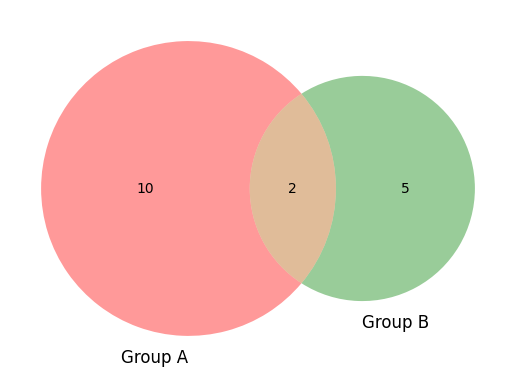

In [3]:
# Use the venn2 function
venn2(subsets=(10, 5, 2), set_labels=("Group A", "Group B"))
plt.show()

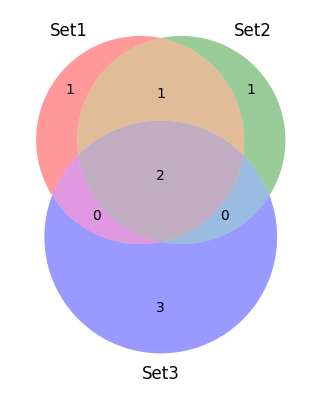

In [4]:
set1 = set(["A", "B", "C", "D"])
set2 = set(["B", "C", "D", "E"])
set3 = set(["C", "D", " E", "F", "G"])

venn3([set1, set2, set3], ("Set1", "Set2", "Set3"))
plt.show()

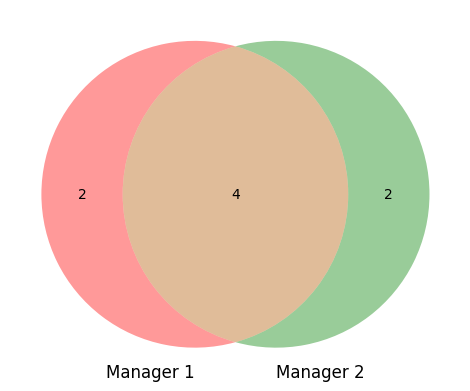

In [5]:
set1 = set(df.loc[df["manager_id"] == 1, "Player"].values)
set2 = set(df.loc[df["manager_id"] == 2, "Player"].values)
venn2([set1, set2], ("Manager 1", "Manager 2"))
plt.show()

# Plotly

## Graph object

In [6]:
def venn_diragram(df):
    fig = go.Figure()

    # Create scatter trace of text labels
    fig.add_trace(
        go.Scatter(
            x=[1, 1.75, 2.5],
            y=[1, 1, 1],
            text=["$A$", "$A+B$", "$B$"],
            mode="text",
            textfont=dict(
                color="black",
                size=18,
                family="Arail",
            ),
        )
    )

    # Update axes properties
    fig.update_xaxes(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
    )

    fig.update_yaxes(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
    )

    # Add circles
    fig.add_shape(
        type="circle", line_color="blue", fillcolor="blue", x0=0, y0=0, x1=2, y1=2
    )
    fig.add_shape(
        type="circle", line_color="gray", fillcolor="gray", x0=1.5, y0=0, x1=3.5, y1=2
    )
    fig.update_shapes(opacity=0.3, xref="x", yref="y")

    fig.update_layout(
        margin=dict(l=20, r=20, b=100), height=600, width=800, plot_bgcolor="white"
    )
    return fig

In [7]:
fig = venn_diragram(df)
fig.show()

## Express

In [8]:
def venn_diragram_px(df):
    fig = (
        px.scatter(
            df,
            size=[0, 0, 0],
            x=[1, 1.75, 2.5],
            y=[1, 1, 1],
            text=["$A$", "$A+B$", "$B$"],
            hover_name=["A", "B", "C"],
        )
        .update_xaxes(
            showticklabels=False,
            showgrid=False,
            zeroline=False,
        )
        .update_yaxes(
            showticklabels=False,
            showgrid=False,
            zeroline=False,
        )
        .add_shape(
            type="circle", line_color="blue", fillcolor="blue", x0=0, y0=0, x1=2, y1=2
        )
        .add_shape(
            type="circle",
            line_color="gray",
            fillcolor="gray",
            x0=1.5,
            y0=0,
            x1=3.5,
            y1=2,
        )
        .update_shapes(opacity=0.3, xref="x", yref="y")
        .update_layout(
            margin=dict(l=20, r=20, b=100), height=600, width=800, plot_bgcolor="white"
        )
    )
    return fig

In [9]:
fig = venn_diragram_px(df)
fig.show()

# Alternative

In [10]:
import matplotlib.pyplot as plt

FIG_SIZE = (10, 6)


class word_list_venn_diagram(object):

    def __init__(self, words, fontsizes, polarities, scale=1.0):
        """
        Arguments:
        ----------
            words: [str 1, ... str N]
                list of strings
            fontsizes: [float 1, ... float N]
                corresponding list of (relative) fontsizes
            polarity: [-1, 0, 1, ..., 0, 1]
                corresponding list of area designations;
                polarity of 0 corresponds to intersection;
                polarities -1 and 1 correspond to the disjoint sets
            scale: float
                scales the size of the circles with respect to the text
                (w.r.t. the maximum joint height of the bounding boxes of the 3 word lists)

        Returns:
        --------
            None

        """

        self.words = np.array(words)
        self.fontsizes = np.array(fontsizes)

        # get bounding boxes of text
        self.bboxes = [
            self._get_bbox(word, size) for word, size in zip(self.words, self.fontsizes)
        ]

        # determine minimum radius of circles
        diameter = 0.0
        unique_polarities = np.unique(polarities)
        for polarity in unique_polarities:
            (idx,) = np.where(polarities == polarity)
            heights = [self.bboxes[ii].height for ii in idx]
            total = np.sum(heights)
            if total > diameter:
                diameter = total
        radius = diameter / 2.0

        # rescale
        radius *= scale
        self.radius = radius

        # arrange bboxes vertically
        for polarity in unique_polarities:
            (idx,) = np.where(polarities == polarity)
            order = self._argsort(self.fontsizes[idx])
            heights = [self.bboxes[ii].height for ii in idx]
            total = np.sum(heights)

            current_height = 0.0
            for ii in idx[order]:
                self.bboxes[ii].y = current_height - total / 2.0
                current_height += self.bboxes[ii].height

        # arrange bboxes horizontally
        # NB: slightly cheeky use of polarity argument
        for ii, _ in enumerate(self.bboxes):
            self.bboxes[ii].x = polarities[ii] * self._get_shift(
                self.bboxes[ii].y, self.radius
            )

        # draw
        self.fig, self.ax = self.draw()

        return

    def draw(self):
        """
        Draws the Venn diagram.
        """

        fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

        # draw circles
        circle_left = plt.Circle(
            (-0.5 * self.radius, 0),
            self.radius,
            color="b",
            fill=False,
            axes=ax,
            linewidth=5,
        )
        circle_right = plt.Circle(
            (+0.5 * self.radius, 0),
            self.radius,
            color="r",
            fill=False,
            axes=ax,
            linewidth=5,
        )
        ax.add_artist(circle_left)
        ax.add_artist(circle_right)

        # draw words
        for ii, (word, bb, fs) in enumerate(
            zip(self.words, self.bboxes, self.fontsizes)
        ):
            ax.text(
                bb.x,
                bb.y,
                word,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=fs,
                bbox=dict(pad=0.0, facecolor="none", edgecolor="none"),
            )

        # update data limits as circles are not registered automatically
        corners = (-1.5 * self.radius, -self.radius), (1.5 * self.radius, self.radius)
        ax.update_datalim(corners)
        ax.autoscale_view()

        # make figure pretty-ish
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.get_figure().set_facecolor("w")
        ax.set_frame_on(False)
        ax.get_figure().canvas.draw()

        return fig, ax

    def _get_bbox(self, word, fontsize):
        """
        Get the bounding box for each word.
        Unfortunately, the bbox is dependent on the renderer,
        so a figure has to be created.
        """
        fig = plt.figure(figsize=FIG_SIZE)
        renderer = fig.canvas.get_renderer()
        text = plt.text(
            0.5,
            0.5,
            word,
            fontsize=fontsize,
            bbox=dict(pad=0.0, facecolor="none", edgecolor="red"),
        )
        bbox = text.get_window_extent(renderer=renderer)
        plt.close(fig)
        return bbox

    def _argsort(self, arr):
        """
        Returns indices to create a sorted array.
        Entries are sorted in such a way that the largest element is in the middle,
        and the size of the elements falls off towards the ends.
        """
        order = np.argsort(arr)
        order = np.r_[order[::2], order[1::2][::-1]]
        return order

    def _get_shift(self, y, r):
        """
        Get point along midline of a waxing moon formed by two overlapping
        circles of radius r as a function of y.
        """
        x1 = np.sqrt(r**2 - y**2) + r / 2.0  # right circle
        x2 = np.sqrt(r**2 - y**2) - r / 2.0  # left circle
        x = x2 + (x1 - x2) / 2.0  # midpoint
        return x


def test():

    test_string = "Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet."
    test_string = "Easiler test string with only 30 or so words to reflect the size of two squads in FPL. Actually, this is a lot harder than it looks. Oh well."
    # get a word list
    words = test_string.split(" ")

    # remove non alphanumeric characters
    words = ["".join(ch for ch in word if ch.isalnum()) for word in words]

    # count occurrences; remove duplicates
    """from collections import Counter

    counter = Counter()
    for word in words:
        counter[word] += 1
    words, counts = counter.keys(), np.array(counter.values())

    # convert counts to reasonable fontsizes
    max_fontsize = 25
    max_count = float(np.max(counts))
    fontsizes = counts / max_count * max_fontsize"""
    fontsizes = list(np.random.random(100) * 20)
    fontsizes = [15] * 100

    # assign random polarities
    polarities = np.random.choice([-1, 0, 1], len(words))
    print(words)
    print(fontsizes)
    print(polarities)

    venn = word_list_venn_diagram(words, fontsizes, polarities, scale=1.5)

    return


def test_with_dummy_df():
    venn = word_list_venn_diagram(
        words=df["Player"],
        fontsizes=[15] * 12,
        polarities=[-1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 1],
        scale=1.5,
    )
    return None

['Easiler', 'test', 'string', 'with', 'only', '30', 'or', 'so', 'words', 'to', 'reflect', 'the', 'size', 'of', 'two', 'squads', 'in', 'FPL', 'Actually', 'this', 'is', 'a', 'lot', 'harder', 'than', 'it', 'looks', 'Oh', 'well']
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
[-1 -1  1 -1 -1  1 -1 -1 -1  0  0 -1  1 -1  1  1  0  0  0  0  0 -1  0  1
 -1  1  0  1  1]


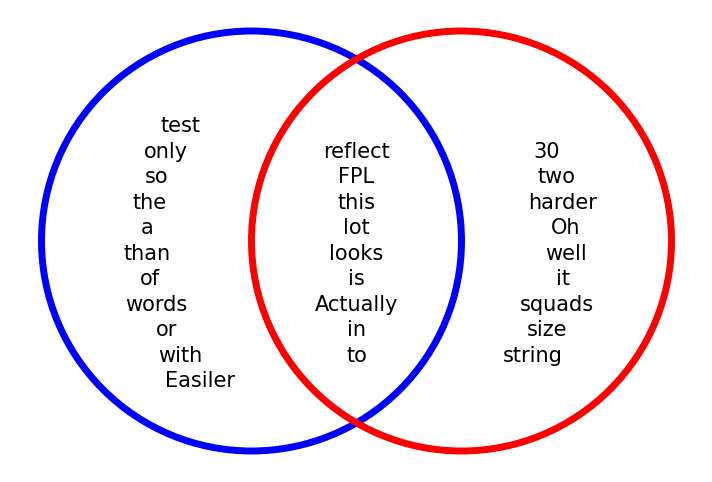

In [11]:
test()

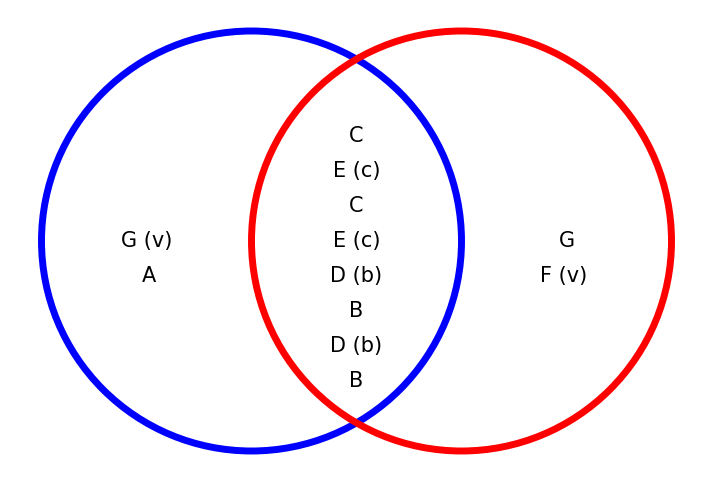

In [12]:
test_with_dummy_df()